# Python Daphnia Analysis Worksheet and Python Processing

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any
from scipy.stats import stats, shapiro, levene, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [ ]:
daphnia_file = "250625_offspring_counts_for_the_daphnia_experiment_cobalt_day_11_day_test v1.csv"
daphnia_df = pd.read_csv(daphnia_file)

In [11]:
daphnia_df.head(5)

,Conc.,Flask Number,Date,Parent Alive Status,Living Offspring,Dead Offspring,Aborted Eggs,Total Offspring,Brood Number,Time Recorded,...,Food Provided,Food Type,Medium Renewed,Renewed Concentration,Old Concentration,pH Renewed,pH Old,O2 (mg/L) Renewed,O2 (mg/L) Old,Comments
0,0.0,1,24/05/25,Alive,0,0,0,0,0,20:00:00,...,Yes,Frozen,Yes,NaN,NaN,8.381,NaN,9.01,NaN,NaN
1,0.0,2,24/05/25,Alive,0,0,0,0,0,20:00:00,...,Yes,Frozen,Yes,NaN,NaN,8.399,NaN,9.03,NaN,NaN
2,0.0,3,24/05/25,Alive,0,0,0,0,0,20:00:00,...,Yes,Frozen,Yes,NaN,NaN,8.390,NaN,8.81,NaN,NaN
3,0.0,4,24/05/25,Alive,0,0,0,0,0,20:00:00,...,Yes,Frozen,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,5,24/05/25,Alive,0,0,0,0,0,20:00:00,...,Yes,Frozen,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Worksheet Cleaning

In [12]:
"""
Parental Mortality Filter and Concentration-Response Analysis

This script filters out accidental deaths and performs Cochran-Armitage trend test
using statsmodels' implementation to determine if parental mortality follows a 
concentration-response pattern.
"""

import pandas as pd
import numpy as np
from scipy import stats
from typing import Tuple, Dict, Any
import warnings
from datetime import datetime
from statsmodels.stats.contingency_tables import Table


def load_and_clean_data(file_path: str) -> pd.DataFrame:
    """
    Load CSV data and perform initial cleaning.

    Parameters
    ----------
    file_path : str
        Path to the CSV file

    Returns
    -------
    pd.DataFrame
        Cleaned dataframe
    """
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()
    
    # Clean string columns
    str_cols = df.select_dtypes(include=['object']).columns
    df[str_cols] = df[str_cols].apply(lambda x: x.str.strip())
    
    # Convert date column with explicit format
    if 'Date' in df.columns:
        try:
            df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y')
        except ValueError:
            df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    
    return df


def filter_accidental_deaths(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove all records from flasks that contain any accidental deaths.

    Identifies flasks with accidental deaths and completely removes all records
    (across all days) associated with those flasks.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe containing at minimum:
        - 'Conc.' (concentration)
        - 'Flask Number' 
        - 'Parent Alive Status' columns

    Returns
    -------
    pd.DataFrame
        Filtered dataframe with all records from accidental death flasks removed.

    Notes
    -----
    This implements a strict filtering policy where any flask showing accidental
    death (status = 'Dead (Accidental)') has all its temporal records removed.
    """
    # Identify flasks with any accidental deaths
    bad_flasks = df.loc[
        df['Parent Alive Status'] == 'Dead (Accidental)',
        ['Conc.', 'Flask Number']
    ].drop_duplicates()

    # Filter using merge/indicator pattern (more efficient than isin)
    filtered_df = (
        df.merge(
            bad_flasks,
            on=['Conc.', 'Flask Number'],
            how='left',
            indicator=True
        )
        .query('_merge == "left_only"')
        .drop(columns='_merge')
    )

    n_removed = len(df) - len(filtered_df)
    print(f"Removed {n_removed} records from {len(bad_flasks)} flasks with accidental deaths")
    return filtered_df



def get_final_day_counts(df: pd.DataFrame) -> pd.DataFrame:
    """
    Get the final day's mortality counts for each concentration.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with Date column

    Returns
    -------
    pd.DataFrame
        Dataframe containing only final day records
    """
    if 'Date' not in df.columns:
        raise ValueError("Dataframe must contain 'Date' column")

    final_dates = (
        df.groupby(['Conc.', 'Flask Number'])['Date']
        .max()
        .reset_index()
    )
    
    return pd.merge(
        df, 
        final_dates, 
        on=['Conc.', 'Flask Number', 'Date'], 
        how='inner'
    )


def prepare_contingency_table(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
    """
    Prepare data for Cochran-Armitage test.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with mortality data

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        (contingency_table, concentrations) where:
        - contingency_table has shape (n_conc, 2) [dead, alive]
        - concentrations are the sorted unique concentration values
    """
    mortality_counts = (
        df.groupby('Conc.')['Parent Alive Status']
        .agg([('dead', lambda x: (x == 'Dead').sum()),
             ('alive', lambda x: (x == 'Alive').sum())])
        .sort_values('Conc.')
    )
    
    return (
        mortality_counts[['dead', 'alive']].values,
        mortality_counts.index.values
    )


def perform_trend_test(
    contingency_table: np.ndarray,
    concentrations: np.ndarray,
    alpha: float = 0.05
) -> Dict[str, Any]:
    """
    Perform Cochran-Armitage trend test using statsmodels.

    Parameters
    ----------
    contingency_table : np.ndarray
        2D array with shape (n_conc, 2) [dead, alive]
    concentrations : np.ndarray
        Array of concentration values
    alpha : float, optional
        Significance level, default 0.05

    Returns
    -------
    Dict[str, Any]
        Dictionary containing test results
    """
    table = Table(contingency_table)
    result = table.test_ordinal_association(
        row_scores=concentrations
    )
    
    # One-tailed p-value (testing specifically for positive trend)
    one_tailed_p = result.pvalue / 2 if result.statistic > 0 else 1.0
    
    return {
        'statistic': result.statistic,
        'two_tailed_p': result.pvalue,
        'one_tailed_p': one_tailed_p,
        'alpha': alpha,
        'significant_positive_trend': (result.statistic > 0) and (one_tailed_p < alpha)
    }


def analyze_concentration_response(
    df: pd.DataFrame,
    alpha: float = 0.05
) -> Dict[str, Any]:
    """
    Analyze if mortality follows concentration-response pattern.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with mortality data
    alpha : float, optional
        Significance level, default 0.05

    Returns
    -------
    Dict[str, Any]
        Dictionary containing analysis results
    """
    contingency_table, concentrations = prepare_contingency_table(df)
    test_results = perform_trend_test(contingency_table, concentrations, alpha)
    
    return {
        **test_results,
        'follows_concentration_response': test_results['significant_positive_trend']
    }


def filter_based_on_trend(df: pd.DataFrame, follows_pattern: bool) -> pd.DataFrame:
    """
    Filter replicates based on concentration-response trend analysis results.

    When no concentration-response pattern exists, removes all records from flasks
    that were dead at their final observation. Applies equally to all concentrations
    including controls (0 concentration).

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe containing at minimum:
        - 'Conc.' (concentration)
        - 'Flask Number'
        - 'Date'
        - 'Parent Alive Status' columns
    follows_pattern : bool
        Whether mortality follows concentration-response pattern (from trend test)

    Returns
    -------
    pd.DataFrame
        Filtered dataframe where:
        - If follows_pattern=True: returns original dataframe
        - If follows_pattern=False: returns only records from flasks alive at final observation

    Notes
    -----
    This implements OECD test guideline recommendations for handling non-concentration-
    dependent mortality. The filtering is applied uniformly across all concentrations.
    """
    if follows_pattern:
        print("Keeping all replicates - mortality follows concentration-response pattern")
        return df.copy()

    print("Filtering dead replicates - no concentration-response pattern detected")

    # Get final status for each flask (including controls)
    final_status = (
        df.sort_values('Date', ascending=True)
        .groupby(['Conc.', 'Flask Number'])
        ['Parent Alive Status']
        .last()
        .reset_index()
        .rename(columns={'Parent Alive Status': 'final_status'})
    )

    # Merge to mark all records
    df_with_status = pd.merge(
        df,
        final_status,
        on=['Conc.', 'Flask Number'],
        how='left'
    )

    # Filter keeping only alive-at-end flasks (no special treatment for controls)
    filtered_df = df_with_status.loc[
        df_with_status['final_status'] == 'Alive',
        df.columns.tolist()  # Maintain original column order
    ].copy()

    n_removed = len(df) - len(filtered_df)
    print(f"Removed {n_removed} records from dead-at-end flasks")
    return filtered_df


def main(file_path: str, alpha: float = 0.05) -> pd.DataFrame:
    """
    Main analysis workflow.

    Parameters
    ----------
    file_path : str
        Path to input CSV file
    alpha : float, optional
        Significance level, default 0.05

    Returns
    -------
    pd.DataFrame
        Final processed dataframe
    """
    print("=== Parental Mortality Analysis ===\n")
    
    try:
        # Data loading and cleaning
        print("1. Loading and cleaning data...")
        df = load_and_clean_data(file_path)
        print(f"   Initial records: {len(df):,}")
        
        # Filter accidental deaths
        print("\n2. Filtering accidental deaths...")
        df_filtered = filter_accidental_deaths(df)
        print(f"   Remaining records: {len(df_filtered):,}")
        
        # Get final day counts
        print("\n3. Identifying final day counts...")
        final_day_df = get_final_day_counts(df_filtered)
        
        # Trend analysis
        print("\n4. Performing trend analysis...")
        analysis_results = analyze_concentration_response(final_day_df, alpha)
        
        print("\nTrend Test Results:")
        print(f"   Statistic: {analysis_results['statistic']:.4f}")
        print(f"   Two-tailed p-value: {analysis_results['two_tailed_p']:.4f}")
        print(f"   One-tailed p-value: {analysis_results['one_tailed_p']:.4f}")
        print(f"   Significant trend (α={alpha}): {analysis_results['significant_positive_trend']}")
        
        # Final filtering
        print("\n5. Applying final filters...")
        final_df = filter_based_on_trend(
            df_filtered,
            analysis_results['follows_concentration_response']
        )
        
        print(f"\nFinal records: {len(final_df):,}")
        print(f"Total removed: {len(df) - len(final_df):,}")
        
        return final_df
    
    except Exception as e:
        print(f"\nError during analysis: {str(e)}")
        raise

In [13]:
daphnia_df_cleaned = main(daphnia_file)

=== Parental Mortality Analysis ===

1. Loading and cleaning data...
   Initial records: 660

2. Filtering accidental deaths...
Removed 33 records from 3 flasks with accidental deaths
   Remaining records: 627

3. Identifying final day counts...

4. Performing trend analysis...

Trend Test Results:
   Statistic: 2800.0000
   Two-tailed p-value: 0.6521
   One-tailed p-value: 0.3261
   Significant trend (α=0.05): False

5. Applying final filters...
Filtering dead replicates - no concentration-response pattern detected
Removed 121 records from dead-at-end flasks

Final records: 506
Total removed: 154


## Time to First Brood

In [32]:
daphnia_df_cleaned.tail(100)

,Conc.,Flask Number,Date,Parent Alive Status,Living Offspring,Dead Offspring,Aborted Eggs,Total Offspring,Brood Number,Time Recorded,...,Food Provided,Food Type,Medium Renewed,Renewed Concentration,Old Concentration,pH Renewed,pH Old,O2 (mg/L) Renewed,O2 (mg/L) Old,Comments
494,100.0,7,2025-05-31,Alive,0,0,0,0,0,20:00:00,...,Yes,Fresh,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
495,100.0,8,2025-05-31,Alive,0,0,0,0,0,20:00:00,...,Yes,Fresh,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
496,100.0,9,2025-05-31,Alive,0,0,0,0,0,20:00:00,...,Yes,Fresh,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497,100.0,10,2025-05-31,Alive,0,0,0,0,0,20:00:00,...,Yes,Fresh,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498,100.0,1,2025-06-01,Alive,0,0,0,0,0,20:00:00,...,Yes,Fresh,Yes,NaN,NaN,8.462,9.114,8.61,13.39,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,200.0,3,2025-06-03,Alive,0,0,0,0,0,NaN,...,Yes,Fresh,Yes,NaN,NaN,8.528,NaN,,NaN,NaN
622,200.0,5,2025-06-03,Alive,0,0,0,0,0,NaN,...,Yes,Fresh,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
623,200.0,6,2025-06-03,Alive,0,0,0,0,0,NaN,...,Yes,Fresh,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
624,200.0,8,2025-06-03,Alive,0,0,0,0,0,NaN,...,Yes,Fresh,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
def calculate_time_to_first_brood(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate time-to-first-brood metrics by concentration, properly handling non-reproducers.

    For each concentration, computes:
    - Counts of total valid organisms (alive parents) and reproducing organisms
    - Descriptive statistics of reproduction timing
    - Explicit handling of non-reproducing organisms

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe containing Daphnia reproduction data with columns:
        - 'Conc.' : float
            Test concentration (µg/L)
        - 'Date' : datetime-compatible
            Observation date (format: DD/MM/YY)
        - 'Flask Number' : int
            Unique replicate identifier
        - 'Living Offspring' : int
            Count of live neonates observed
        - 'Parent Alive Status' : str
            Contains 'Alive' or other status indicating parent survival

    Returns
    -------
    pd.DataFrame
        Summary statistics with columns:
        - 'Concentration' : float
            Test concentration (µg/L)
        - 'N_Total' : int
            Total number of valid replicates (alive parents)
        - 'N_Reproduced' : int
            Number of replicates with reproduction
        - 'Reproduction_Rate' : float
            Proportion of reproducing replicates (N_Reproduced/N_Total)
        - 'Min_Days' : float
            Earliest observed reproduction time (days)
        - 'Median_Days' : float
            Median reproduction time (days)
        - 'Q1' : float
            25th percentile of reproduction times
        - 'Q3' : float
            75th percentile of reproduction times
        - 'Mean_Days' : float
            Mean reproduction time (days)
        - 'Std_Days' : float
            Standard deviation of reproduction times
    """
    # Convert dates and establish baseline
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    start_date = df['Date'].min()

    # Identify valid organisms (alive parents)
    valid_organisms = df[df['Parent Alive Status'].str.strip().str.lower() == 'alive'].copy()
    
    # Identify first reproduction events among valid organisms
    reproducing_flasks = valid_organisms[valid_organisms['Living Offspring'] > 0].copy()
    first_reproduction = (
        reproducing_flasks.groupby(['Conc.', 'Flask Number'])
        ['Date'].min()
        .reset_index()
    )
    first_reproduction['days_to_brood'] = (
        (first_reproduction['Date'] - start_date).dt.total_seconds() / (24 * 3600)  # Convert to days
    )

    # Create complete replicate list of valid organisms
    all_valid_replicates = (
        valid_organisms.groupby(['Conc.', 'Flask Number'])
        .size()
        .reset_index()[['Conc.', 'Flask Number']]
    )

    # Merge reproduction data (preserve NaNs for non-reproducers)
    merged_data = pd.merge(
        left=all_valid_replicates,
        right=first_reproduction[['Conc.', 'Flask Number', 'days_to_brood']],
        on=['Conc.', 'Flask Number'],
        how='left',
        validate='one_to_one'
    )

    # Calculate summary statistics
    stats = merged_data.groupby('Conc.').agg(
        N_Total=('Flask Number', 'count'),  # Total alive parents
        N_Reproduced=('days_to_brood', lambda x: x.notna().sum()),  # Those that reproduced
        Min_Days=('days_to_brood', lambda x: x.min() if x.notna().any() else np.nan),
        Median_Days=('days_to_brood', lambda x: x.median() if x.notna().any() else np.nan),
        Q1=('days_to_brood', lambda x: x.quantile(0.25) if x.notna().any() else np.nan),
        Q3=('days_to_brood', lambda x: x.quantile(0.75) if x.notna().any() else np.nan),
        Mean_Days=('days_to_brood', lambda x: x.mean() if x.notna().any() else np.nan),
        Std_Days=('days_to_brood', lambda x: x.std(ddof=1) if x.notna().sum() > 1 else np.nan)
    ).reset_index().rename(columns={'Conc.': 'Concentration'})

    # Add derived metrics
    stats['Reproduction_Rate'] = stats['N_Reproduced'] / stats['N_Total']

    return stats[[
        'Concentration', 'N_Total', 'N_Reproduced', 'Reproduction_Rate',
        'Min_Days', 'Median_Days', 'Q1', 'Q3', 'Mean_Days', 'Std_Days'
    ]]

In [46]:
# Issue with this code is that it include the N_total for the number that were reproducing. However, 8 didn't reproduce in the control. Whilst  
# The n reproduced makes sense, but the median days does not. The median days should be the median of the time since the first brood. 
# Check through the code tomorrow to review in more detail and make appropriate corrections. 
calculate_time_to_first_brood(daphnia_df_cleaned)

,Concentration,N_Total,N_Reproduced,Reproduction_Rate,Min_Days,Median_Days,Q1,Q3,Mean_Days,Std_Days
0,0.0,10,8,0.800000,8.0,8.5,8.0,9.0,8.5,0.534522
1,12.5,6,5,0.833333,8.0,9.0,9.0,9.0,8.8,0.447214
2,25.0,7,5,0.714286,9.0,9.0,9.0,9.0,9.2,0.447214
3,50.0,7,5,0.714286,9.0,10.0,9.0,10.0,9.6,0.547723
4,100.0,10,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
5,200.0,6,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


## Total Number of Offspring Per Flask

In [35]:
def calculate_total_offspring_per_flask(data: pd.DataFrame) -> pd.DataFrame:
    """Calculate the total number of living offspring per flask for each concentration.

    Parameters
    ----------
    data : pd.DataFrame
        The input DataFrame containing Daphnia experiment data with columns:
        'Conc.', 'Flask Number', and 'Living Offspring'.

    Returns
    -------
    pd.DataFrame
        A DataFrame with columns 'Concentration', 'Flask Number', and 'Total Living Offspring',
        showing the sum of living offspring for each flask at each concentration.
    """
    # Group by concentration and flask number, then sum the living offspring
    result = (
        data.groupby(["Conc.", "Flask Number"])["Living Offspring"]
        .sum()
        .reset_index()
        .rename(
            columns={
                "Conc.": "Concentration",
                "Living Offspring": "Total Living Offspring",
            }
        )
    )
    
    return result

In [36]:
total_offspring_per_flask_df = calculate_total_offspring_per_flask(daphnia_df_cleaned)

In [37]:
total_offspring_per_flask_df.head(10)

,Concentration,Flask Number,Total Living Offspring
0,0.0,1,4
1,0.0,2,11
2,0.0,3,0
3,0.0,4,7
4,0.0,5,5
5,0.0,6,13
6,0.0,7,2
7,0.0,8,0
8,0.0,9,6
9,0.0,10,4


In [38]:
def calculate_total_offspring_per_concentration(data: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the total number of living offspring per concentration.

    Parameters
    ----------
    data : pd.DataFrame
        The input DataFrame containing Daphnia experiment data with columns:
        'Conc.' and 'Living Offspring'.

    Returns
    -------
    pd.DataFrame
        A DataFrame with columns 'Concentration' and 'Total Living Offspring',
        showing the sum of living offspring for each concentration.
    """
    result = (
        data.groupby("Conc.")["Living Offspring"]
        .sum()
        .reset_index()
        .rename(
            columns={
                "Conc.": "Concentration",
                "Living Offspring": "Total Living Offspring",
            }
        )
    )

    return result


In [39]:
calculate_total_offspring_per_concentration(daphnia_df_cleaned)

,Concentration,Total Living Offspring
0,0.0,52
1,12.5,15
2,25.0,23
3,50.0,19
4,100.0,0
5,200.0,0


In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import kruskal, mannwhitneyu, f_oneway, shapiro, levene, bartlett
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
import string
import warnings

def check_sufficient_replicates(df: pd.DataFrame, min_replicates: int = 3, 
                               recommended_replicates: int = 5) -> dict:
    """
    Check if there are sufficient replicates for each concentration group.
    
    Args:
        df: DataFrame containing the data
        min_replicates: Minimum number of replicates required per group
        recommended_replicates: Recommended number of replicates per group
    
    Returns:
        dict: Results of replicate check including recommendations
    """
    concentrations = sorted(df['Concentration'].unique())
    
    replicate_info = {
        'sufficient': True,
        'groups': {},
        'min_n': float('inf'),
        'max_n': 0,
        'total_n': len(df),
        'recommendations': [],
        'proceed_with_analysis': True
    }
    
    print("=" * 60)
    print("CHECKING SAMPLE SIZE ADEQUACY")
    print("=" * 60)
    
    print(f"Minimum replicates required: {min_replicates}")
    print(f"Recommended replicates: {recommended_replicates}")
    print(f"Total sample size: {len(df)}")
    print(f"Number of groups: {len(concentrations)}")
    print("-" * 40)
    
    insufficient_groups = []
    small_groups = []
    
    for conc in concentrations:
        group_data = df[df['Concentration'] == conc]['Total Living Offspring']
        n = len(group_data)
        
        replicate_info['groups'][conc] = {
            'n': n,
            'sufficient': n >= min_replicates,
            'recommended': n >= recommended_replicates,
            'mean': group_data.mean(),
            'std': group_data.std()
        }
        
        replicate_info['min_n'] = min(replicate_info['min_n'], n)
        replicate_info['max_n'] = max(replicate_info['max_n'], n)
        
        # Status indicators
        if n < min_replicates:
            status = "✗ INSUFFICIENT"
            insufficient_groups.append(conc)
        elif n < recommended_replicates:
            status = "⚠ MINIMAL"
            small_groups.append(conc)
        else:
            status = "✓ ADEQUATE"
        
        print(f"Concentration {conc}: n = {n:2d} - {status}")
    
    print("-" * 40)
    
    # Overall assessment
    if insufficient_groups:
        replicate_info['sufficient'] = False
        replicate_info['proceed_with_analysis'] = False
        print("❌ ANALYSIS NOT RECOMMENDED")
        print(f"   Groups with insufficient replicates: {insufficient_groups}")
        print(f"   These groups have < {min_replicates} replicates")
        
        replicate_info['recommendations'].extend([
            f"Collect more data for concentrations: {', '.join(map(str, insufficient_groups))}",
            f"Target at least {min_replicates} replicates per group (minimum)",
            f"Ideally aim for {recommended_replicates}+ replicates per group for robust analysis"
        ])
        
    elif small_groups:
        print("⚠ ANALYSIS POSSIBLE BUT LIMITED")
        print(f"   Groups with minimal replicates: {small_groups}")
        print(f"   These groups have {min_replicates}-{recommended_replicates-1} replicates")
        
        replicate_info['recommendations'].extend([
            f"Consider collecting more data for concentrations: {', '.join(map(str, small_groups))}",
            f"Results may have limited statistical power",
            f"Interpret results cautiously, especially for groups with n < {recommended_replicates}"
        ])
        
    else:
        print("✅ ANALYSIS RECOMMENDED")
        print("   All groups have adequate replicates")
        
        replicate_info['recommendations'].append(
            "Sample sizes are adequate for reliable statistical analysis"
        )
    
    # Additional considerations
    print(f"\nSample size summary:")
    print(f"   Range: {replicate_info['min_n']} - {replicate_info['max_n']} replicates per group")
    print(f"   Total: {replicate_info['total_n']} observations across {len(concentrations)} groups")
    
    # Balance check
    if replicate_info['max_n'] > 2 * replicate_info['min_n']:
        print(f"⚠ WARNING: Unbalanced design detected")
        print(f"   Largest group ({replicate_info['max_n']}) > 2× smallest group ({replicate_info['min_n']})")
        replicate_info['recommendations'].append(
            "Consider balancing group sizes for optimal statistical power"
        )
    
    # Power considerations
    if replicate_info['min_n'] < 5:
        print(f"⚠ LOW POWER WARNING: Smallest group has only {replicate_info['min_n']} replicates")
        print("   May have difficulty detecting moderate effect sizes")
        replicate_info['recommendations'].append(
            "Low statistical power - may miss biologically relevant differences"
        )
    
    print("=" * 60)
    
    # Print recommendations
    if replicate_info['recommendations']:
        print("RECOMMENDATIONS:")
        for i, rec in enumerate(replicate_info['recommendations'], 1):
            print(f"{i}. {rec}")
        print("=" * 60)
    
    return replicate_info

def check_parametric_assumptions(df: pd.DataFrame, alpha: float = 0.05):
    """
    Check assumptions for parametric testing (ANOVA).
    
    Args:
        df: DataFrame containing the data
        alpha: Significance level for assumption tests
    
    Returns:
        dict: Results of assumption tests
    """
    concentrations = sorted(df['Concentration'].unique())
    groups = [df[df['Concentration'] == conc]['Total Living Offspring'].values 
              for conc in concentrations]
    
    assumptions = {
        'normality': {'met': True, 'tests': {}, 'recommendation': ''},
        'homogeneity': {'met': True, 'tests': {}, 'recommendation': ''},
        'independence': {'assumed': True, 'note': 'Independence must be verified by experimental design'},
        'overall_recommendation': ''
    }
    
    print("=" * 60)
    print("CHECKING PARAMETRIC TEST ASSUMPTIONS")
    print("=" * 60)
    
    # 1. Test for Normality
    print("\n1. NORMALITY TEST (Shapiro-Wilk)")
    print("-" * 40)
    normality_violations = 0
    
    for conc in concentrations:
        group_data = df[df['Concentration'] == conc]['Total Living Offspring'].values
        
        # Only test if group has enough data points (Shapiro-Wilk works best with 3-5000 samples)
        if len(group_data) >= 3:
            stat, p_val = shapiro(group_data)
            is_normal = p_val > alpha
            assumptions['normality']['tests'][conc] = {'stat': stat, 'p_value': p_val, 'normal': is_normal}
            
            status = "✓ Normal" if is_normal else "✗ Non-normal"
            print(f"Concentration {conc}: W = {stat:.4f}, p = {p_val:.4f} - {status}")
            
            if not is_normal:
                normality_violations += 1
        else:
            print(f"Concentration {conc}: Sample too small (n={len(group_data)}) for reliable normality test")
            assumptions['normality']['tests'][conc] = {'stat': None, 'p_value': None, 'normal': None}
    
    if normality_violations > 0:
        assumptions['normality']['met'] = False
        assumptions['normality']['recommendation'] = f"Non-parametric tests recommended ({normality_violations} groups violated normality)"
    else:
        assumptions['normality']['recommendation'] = "Parametric tests acceptable (normality assumption met)"
    
    # 2. Test for Homogeneity of Variance
    print(f"\n2. HOMOGENEITY OF VARIANCE TESTS")
    print("-" * 40)
    
    # Levene's test (robust to non-normality)
    levene_stat, levene_p = levene(*groups)
    levene_met = levene_p > alpha
    assumptions['homogeneity']['tests']['levene'] = {'stat': levene_stat, 'p_value': levene_p, 'met': levene_met}
    
    # Bartlett's test (assumes normality)
    bartlett_stat, bartlett_p = bartlett(*groups)
    bartlett_met = bartlett_p > alpha
    assumptions['homogeneity']['tests']['bartlett'] = {'stat': bartlett_stat, 'p_value': bartlett_p, 'met': bartlett_met}
    
    levene_status = "✓ Equal variances" if levene_met else "✗ Unequal variances"
    bartlett_status = "✓ Equal variances" if bartlett_met else "✗ Unequal variances"
    
    print(f"Levene's Test: W = {levene_stat:.4f}, p = {levene_p:.4f} - {levene_status}")
    print(f"Bartlett's Test: T = {bartlett_stat:.4f}, p = {bartlett_p:.4f} - {bartlett_status}")
    
    # Use Levene's test as primary (more robust)
    if not levene_met:
        assumptions['homogeneity']['met'] = False
        assumptions['homogeneity']['recommendation'] = "Non-parametric tests recommended (variance assumption violated)"
    else:
        assumptions['homogeneity']['recommendation'] = "Parametric tests acceptable (homogeneity assumption met)"
    
    # 3. Independence assumption
    print(f"\n3. INDEPENDENCE")
    print("-" * 40)
    print("✓ Assumed based on experimental design (cannot be statistically tested)")
    print("  Verify: Random sampling, no repeated measures, no clustering")
    
    # Overall recommendation
    print(f"\n" + "=" * 60)
    print("OVERALL RECOMMENDATION")
    print("=" * 60)
    
    if assumptions['normality']['met'] and assumptions['homogeneity']['met']:
        assumptions['overall_recommendation'] = 'parametric'
        print("✓ PARAMETRIC TESTS RECOMMENDED")
        print("  - Use: One-way ANOVA + Tukey's HSD")
        print("  - All assumptions appear to be met")
    else:
        assumptions['overall_recommendation'] = 'non_parametric'
        print("✗ NON-PARAMETRIC TESTS RECOMMENDED")
        print("  - Use: Kruskal-Wallis + Mann-Whitney U")
        violated = []
        if not assumptions['normality']['met']:
            violated.append("normality")
        if not assumptions['homogeneity']['met']:
            violated.append("homogeneity of variance")
        print(f"  - Violated assumptions: {', '.join(violated)}")
    
    print("=" * 60)
    
    return assumptions

def perform_parametric_analysis(df: pd.DataFrame, alpha: float = 0.05):
    """Perform parametric statistical analysis (ANOVA + Tukey's HSD)."""
    concentrations = sorted(df['Concentration'].unique())
    groups = [df[df['Concentration'] == conc]['Total Living Offspring'].values 
              for conc in concentrations]
    
    print(f"\nPERFORMING PARAMETRIC ANALYSIS")
    print("-" * 40)
    
    # One-way ANOVA
    f_stat, p_overall = f_oneway(*groups)
    print(f"One-way ANOVA: F = {f_stat:.4f}, p = {p_overall:.4f}")
    
    if p_overall >= alpha:
        print("No significant differences found between groups")
        return {conc: 'a' for conc in concentrations}
    
    # Tukey's HSD for post-hoc comparisons
    print(f"\nPost-hoc analysis: Tukey's HSD")
    tukey_results = pairwise_tukeyhsd(df['Total Living Offspring'], 
                                    df['Concentration'], 
                                    alpha=alpha)
    print(tukey_results)
    
    # Extract significant pairs from Tukey results
    tukey_summary = tukey_results.summary()
    significant_pairs = []
    
    for i in range(1, len(tukey_summary.data)):  # Skip header row
        row = tukey_summary.data[i]
        group1, group2, meandiff, p_adj, lower, upper, reject = row
        if reject:  # reject = True means significant difference
            significant_pairs.append((group1, group2))
    
    # Generate letter symbols
    letter_symbols = generate_letter_symbols_from_pairs(concentrations, significant_pairs)
    
    return letter_symbols

def perform_nonparametric_analysis(df: pd.DataFrame, alpha: float = 0.05):
    """Perform non-parametric statistical analysis (Kruskal-Wallis + Mann-Whitney U)."""
    concentrations = sorted(df['Concentration'].unique())
    groups = [df[df['Concentration'] == conc]['Total Living Offspring'].values 
              for conc in concentrations]
    
    print(f"\nPERFORMING NON-PARAMETRIC ANALYSIS")
    print("-" * 40)
    
    # Kruskal-Wallis test
    h_stat, p_overall = kruskal(*groups)
    print(f"Kruskal-Wallis test: H = {h_stat:.4f}, p = {p_overall:.4f}")
    
    if p_overall >= alpha:
        print("No significant differences found between groups")
        return {conc: 'a' for conc in concentrations}
    
    # Pairwise Mann-Whitney U tests
    print(f"\nPost-hoc analysis: Mann-Whitney U tests")
    p_values = {}
    significant_pairs = []
    
    for i, j in combinations(range(len(concentrations)), 2):
        conc1, conc2 = concentrations[i], concentrations[j]
        stat, p_val = mannwhitneyu(groups[i], groups[j], alternative='two-sided')
        p_values[(conc1, conc2)] = p_val
    
    # Apply Bonferroni correction
    n_comparisons = len(p_values)
    corrected_alpha = alpha / n_comparisons
    print(f"Bonferroni corrected α = {corrected_alpha:.4f}")
    
    for (conc1, conc2), p_val in p_values.items():
        is_significant = p_val < corrected_alpha
        significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if is_significant else "ns"
        print(f"{conc1} vs {conc2}: p = {p_val:.4f} {significance}")
        
        if is_significant:
            significant_pairs.append((conc1, conc2))
    
    # Generate letter symbols
    letter_symbols = generate_letter_symbols_from_pairs(concentrations, significant_pairs)
    
    return letter_symbols

def generate_letter_symbols_from_pairs(concentrations, significant_pairs):
    """
    Generate compact letter symbols (e.g., 'a', 'ab', 'b') based on significant pairwise differences.
    Groups not significantly different can share a letter.
    """
    from collections import defaultdict
    import string

    n = len(concentrations)
    conc_to_idx = {conc: i for i, conc in enumerate(concentrations)}

    # Adjacency matrix of pairwise significant differences (False means can share)
    cannot_share = np.zeros((n, n), dtype=bool)
    for conc1, conc2 in significant_pairs:
        i, j = conc_to_idx[conc1], conc_to_idx[conc2]
        cannot_share[i, j] = True
        cannot_share[j, i] = True

    # Store letter assignments
    letters = list(string.ascii_lowercase)
    conc_letters = {conc: "" for conc in concentrations}
    used_letters = []

    for i, conc in enumerate(concentrations):
        assigned = False
        for letter in used_letters:
            # Check if conc can share this letter with all others already assigned that letter
            conflict = False
            for other_conc, other_letters in conc_letters.items():
                if letter in other_letters:
                    j = conc_to_idx[other_conc]
                    if cannot_share[i, j]:
                        conflict = True
                        break
            if not conflict:
                conc_letters[conc] += letter
                assigned = True
        if not assigned:
            # Assign a new letter
            new_letter = letters[len(used_letters)]
            used_letters.append(new_letter)
            conc_letters[conc] += new_letter

    return conc_letters



def plot_boxplot_offspring_by_concentration_with_smart_stats(df: pd.DataFrame, alpha: float = 0.05, 
                                                           force_test: str = None,
                                                           min_replicates: int = 3,
                                                           recommended_replicates: int = 5) -> None:
    """
    Plot boxplot with automatic replicate checking, assumption testing, and appropriate statistical analysis.
    
    Args:
        df: DataFrame containing the Daphnia experiment data
        alpha: Significance level for statistical tests (default 0.05)
        force_test: Force specific test type ('parametric' or 'non_parametric'), 
                   or None for automatic selection
        min_replicates: Minimum number of replicates required per group
        recommended_replicates: Recommended number of replicates per group
    """
    
    # First, check if we have sufficient replicates
    replicate_check = check_sufficient_replicates(df, min_replicates, recommended_replicates)
    
    # If insufficient replicates, stop here and provide guidance
    if not replicate_check['proceed_with_analysis']:
        print("\n" + "!" * 60)
        print("ANALYSIS TERMINATED - INSUFFICIENT REPLICATES")
        print("!" * 60)
        print("Cannot proceed with statistical analysis due to insufficient sample sizes.")
        print("Please collect more data before conducting statistical comparisons.")
        print("\nTo override this check and proceed anyway (NOT RECOMMENDED), you can:")
        print("1. Lower the min_replicates parameter (current:", min_replicates, ")")
        print("2. Or use force_analysis=True in a modified version of this function")
        return None
    
    # Check assumptions unless forced to use specific test
    if force_test is None:
        assumptions = check_parametric_assumptions(df, alpha)
        test_type = assumptions['overall_recommendation']
    else:
        test_type = force_test
        print(f"Forced to use {test_type} tests (assumption checking skipped)")
    
    # Perform appropriate statistical analysis
    if test_type == 'parametric':
        letter_symbols = perform_parametric_analysis(df, alpha)
        test_description = "One-way ANOVA + Tukey's HSD"
    else:
        letter_symbols = perform_nonparametric_analysis(df, alpha)
        test_description = "Kruskal-Wallis + Mann-Whitney U (Bonferroni corrected)"
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 8))

    # Plot boxplot (shows medians by default)
    sns.boxplot(data=df,
                x="Concentration",
                y="Total Living Offspring",
                showcaps=True,
                boxprops={'facecolor': 'lightblue'},
                medianprops={'color': 'red'},
                flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'gray'},
                ax=ax)

    # Overlay stripplot (raw data points)
    sns.stripplot(data=df,
                x="Concentration",
                y="Total Living Offspring",
                color="black",
                alpha=0.3,
                jitter=True,
                ax=ax)

    # Calculate and overlay mean per group
    group_means = df.groupby("Concentration")["Total Living Offspring"].mean()

    for i, (x_cat, mean_val) in enumerate(group_means.items()):
        ax.plot(i, mean_val, marker='D', color='white', markersize=8, label='Mean' if i == 0 else "")

    # Optional: add legend for the mean marker
    # ax.legend(loc='upper right')

    # Add letter symbols (group significance)
    concentrations = sorted(df['Concentration'].unique())
    letter_positions = {}

    for i, conc in enumerate(concentrations):
        conc_data = df[df['Concentration'] == conc]['Total Living Offspring']
        letter_positions[conc] = conc_data.max()

    y_max = max(letter_positions.values())
    padding = (y_max - df['Total Living Offspring'].min()) * 0.08

    for i, conc in enumerate(concentrations):
        letter = letter_symbols[conc]
        y_pos = letter_positions[conc] + padding

        # Add sample size information
        #n = replicate_check['groups'][conc]['n']
        label = f"{letter}"

        ax.text(i, y_pos, label, ha='center', va='bottom',
                fontsize=12, fontweight='bold', color='black',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black', alpha=0.8))

    # Customize plot
    sample_info = f"Sample sizes: {replicate_check['min_n']}-{replicate_check['max_n']} per group"
    ax.set_title('Total Living Offspring by Concentration\n', fontsize=14)
    ax.set_xlabel('Concentration', fontsize=12)
    ax.set_ylabel('Number of Living Offspring', fontsize=12)

    print(f'Statistical Analysis: {test_description}\n' +
        f'{sample_info}\n' +
        '(Groups with same letter are not significantly different)')

    # Uncomment this section if you want to show test info in a box:
    # test_info = f'Statistical test: {test_description}\nSignificance level: α = {alpha}\n'
    # test_info += f'Sample adequacy: {"✓ Adequate" if replicate_check["sufficient"] else "⚠ Minimal"}'
    # if force_test is None:
    #     test_info += f'\nTest selection: Automatic'
    # else:
    #     test_info += f'\nTest selection: Forced ({force_test})'

    # ax.text(0.02, 0.98, test_info,
    #         transform=ax.transAxes, fontsize=10, verticalalignment='top',
    #         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))

    plt.tight_layout()
    plt.show()

    # Print interpretation
    print("\n" + "=" * 60)
    print("RESULTS INTERPRETATION")
    print("=" * 60)
    print("Letter symbol interpretation:")
    print("- Groups with the same letter are NOT significantly different")
    print("- Groups with different letters ARE significantly different")
    print(f"- Statistical test used: {test_description}")
    print(f"- Significance level: α = {alpha}")
    
    # Show groupings with sample sizes
    print(f"\nStatistical groupings:")
    for conc in concentrations:
        n = replicate_check['groups'][conc]['n']
        mean_val = replicate_check['groups'][conc]['mean']
        print(f"Concentration {conc}: Group '{letter_symbols[conc]}' (n={n}, mean={mean_val:.1f})")
    
    # Sample size warnings if applicable
    if not replicate_check['sufficient'] or replicate_check['min_n'] < recommended_replicates:
        print(f"\n⚠ SAMPLE SIZE CONSIDERATIONS:")
        for rec in replicate_check['recommendations']:
            print(f"  • {rec}")

# Convenience functions for specific test types
def plot_boxplot_force_parametric(df: pd.DataFrame, alpha: float = 0.05, 
                                 min_replicates: int = 3, recommended_replicates: int = 5):
    """Force parametric analysis with replicate checking."""
    plot_boxplot_offspring_by_concentration_with_smart_stats(df, alpha, 
                                                           force_test='parametric',
                                                           min_replicates=min_replicates,
                                                           recommended_replicates=recommended_replicates)

def plot_boxplot_force_nonparametric(df: pd.DataFrame, alpha: float = 0.05,
                                    min_replicates: int = 3, recommended_replicates: int = 5):
    """Force non-parametric analysis with replicate checking."""
    plot_boxplot_offspring_by_concentration_with_smart_stats(df, alpha, 
                                                           force_test='non_parametric',
                                                           min_replicates=min_replicates,
                                                           recommended_replicates=recommended_replicates)

def check_replicates_only(df: pd.DataFrame, min_replicates: int = 3, 
                         recommended_replicates: int = 5):
    """Standalone function to check replicate adequacy without running full analysis."""
    return check_sufficient_replicates(df, min_replicates, recommended_replicates)

# Example usage:
# Check replicates only:
# replicate_info = check_replicates_only(df)
#
# Automatic analysis with replicate checking:
# plot_boxplot_offspring_by_concentration_with_smart_stats(df)
#
# Custom replicate requirements:
# plot_boxplot_offspring_by_concentration_with_smart_stats(df, min_replicates=5, recommended_replicates=8)
#
# Force specific tests with replicate checking:
# plot_boxplot_force_parametric(df, min_replicates=3)
# plot_boxplot_force_nonparametric(df, min_replicates=3)

CHECKING SAMPLE SIZE ADEQUACY
Minimum replicates required: 3
Recommended replicates: 5
Total sample size: 46
Number of groups: 6
----------------------------------------
Concentration 0.0: n = 10 - ✓ ADEQUATE
Concentration 12.5: n =  6 - ✓ ADEQUATE
Concentration 25.0: n =  7 - ✓ ADEQUATE
Concentration 50.0: n =  7 - ✓ ADEQUATE
Concentration 100.0: n = 10 - ✓ ADEQUATE
Concentration 200.0: n =  6 - ✓ ADEQUATE
----------------------------------------
✅ ANALYSIS RECOMMENDED
   All groups have adequate replicates

Sample size summary:
   Range: 6 - 10 replicates per group
   Total: 46 observations across 6 groups
RECOMMENDATIONS:
1. Sample sizes are adequate for reliable statistical analysis
CHECKING PARAMETRIC TEST ASSUMPTIONS

1. NORMALITY TEST (Shapiro-Wilk)
----------------------------------------
Concentration 0.0: W = 0.9337, p = 0.4848 - ✓ Normal
Concentration 12.5: W = 0.9819, p = 0.9606 - ✓ Normal
Concentration 25.0: W = 0.8325, p = 0.0845 - ✓ Normal
Concentration 50.0: W = 0.9305,

/home/abrisham/miniconda3/envs/onehealth/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/home/abrisham/miniconda3/envs/onehealth/lib/python3.13/site-packages/scipy/stats/_morestats.py:2901: RuntimeWarning: divide by zero encountered in log
  - xp.sum((Ni - 1)*xp.log(ssq), axis=0, dtype=dtype))
/home/abrisham/miniconda3/envs/onehealth/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Statistical Analysis: Kruskal-Wallis + Mann-Whitney U (Bonferroni corrected)
Sample sizes: 6-10 per group
(Groups with same letter are not significantly different)


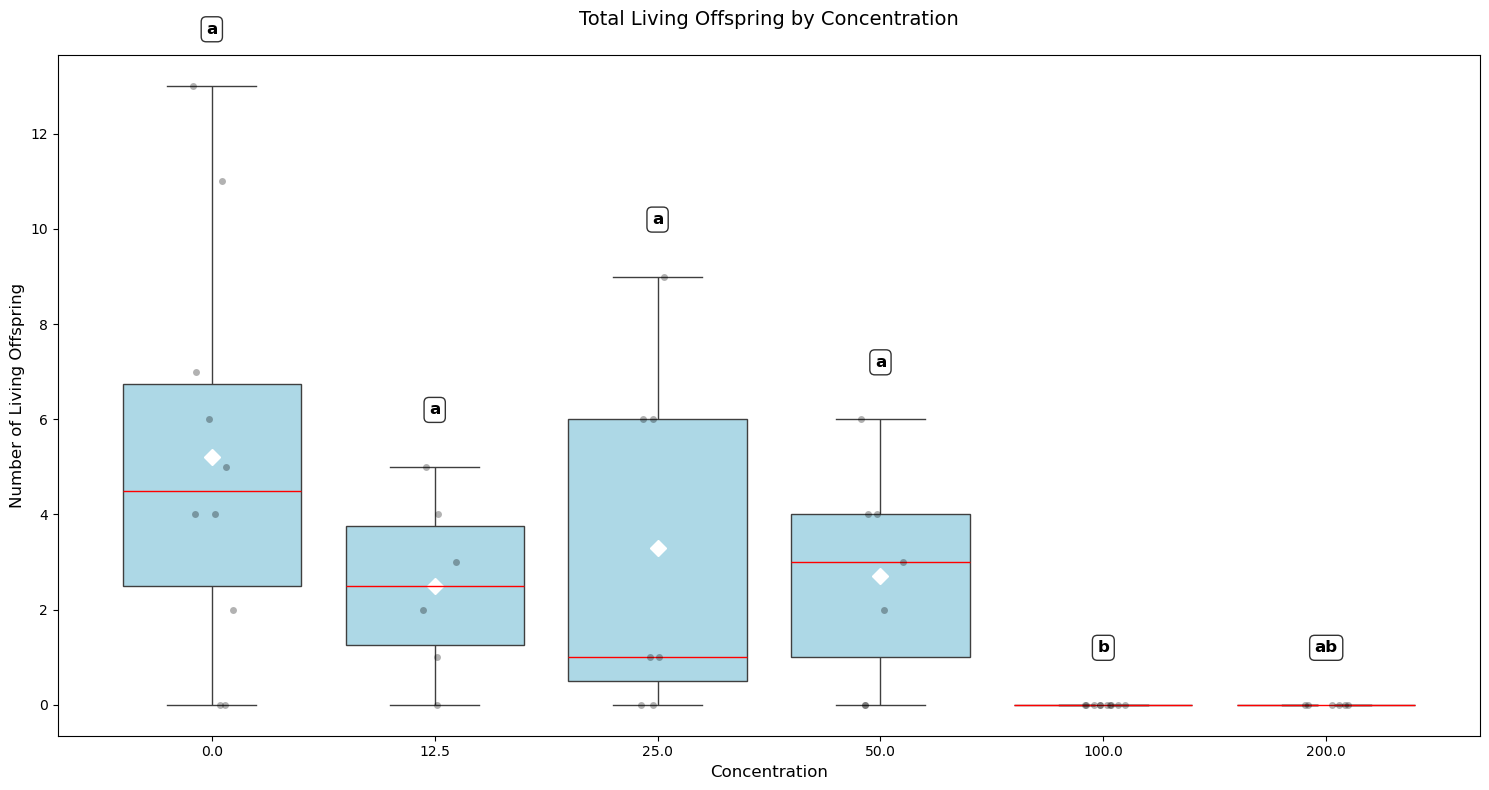


RESULTS INTERPRETATION
Letter symbol interpretation:
- Groups with the same letter are NOT significantly different
- Groups with different letters ARE significantly different
- Statistical test used: Kruskal-Wallis + Mann-Whitney U (Bonferroni corrected)
- Significance level: α = 0.05

Statistical groupings:
Concentration 0.0: Group 'a' (n=10, mean=5.2)
Concentration 12.5: Group 'a' (n=6, mean=2.5)
Concentration 25.0: Group 'a' (n=7, mean=3.3)
Concentration 50.0: Group 'a' (n=7, mean=2.7)
Concentration 100.0: Group 'b' (n=10, mean=0.0)
Concentration 200.0: Group 'ab' (n=6, mean=0.0)


In [88]:
plot_boxplot_offspring_by_concentration_with_smart_stats(total_offspring_per_flask_df)

In [72]:
def plot_cumulative_reproduction_with_variability(df, output_path=None):
    """Plot cumulative reproduction of Daphnia with variability (mean ± SEM).
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe containing reproduction data. Must contain columns:
        - 'Date': Date of observation (format: dd/mm/yy)
        - 'Conc.': Concentration in µg/L
        - 'Flask Number': Replicate identifier
        - 'Living Offspring': Count of living offspring
    output_path : str, optional
        If provided, saves the plot to this path. If None, displays the plot.
    
    Returns
    -------
    matplotlib.figure.Figure
        The generated figure object.
    
    Examples
    --------
    >>> df = pd.DataFrame({
    ...     'Date': ['01/01/21', '02/01/21', '01/01/21', '02/01/21'],
    ...     'Conc.': [0, 0, 10, 10],
    ...     'Flask Number': [1, 1, 2, 2],
    ...     'Living Offspring': [5, 3, 2, 4]
    ... })
    >>> fig = plot_cumulative_reproduction_with_variability(df)
    """
    # Convert and sort as before
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y')
    df = df.sort_values(['Conc.', 'Flask Number', 'Date'])
    df['Day'] = (df['Date'] - df['Date'].min()).dt.days + 1

    # Calculate cumulative sum per replicate
    df['Cumulative Offspring'] = df.groupby(['Conc.', 'Flask Number'])['Living Offspring'].cumsum()

    # Compute mean ± SEM per concentration per day
    stats_df = df.groupby(['Conc.', 'Day'])['Cumulative Offspring'].agg(['mean', 'sem']).reset_index()

    # Pivot for plotting
    mean_df = stats_df.pivot(index='Day', columns='Conc.', values='mean')
    sem_df = stats_df.pivot(index='Day', columns='Conc.', values='sem')

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    for conc in mean_df.columns:
        ax.plot(
            mean_df.index,
            mean_df[conc],
            label=f'{conc} µg/L',
            marker='o'
        )
        ax.fill_between(
            mean_df.index,
            mean_df[conc] - sem_df[conc],
            mean_df[conc] + sem_df[conc],
            alpha=0.2
        )

    ax.set_title('Cumulative Reproduction of Daphnia (Individuals)')
    ax.set_xlabel('Day')
    ax.set_ylabel('Cumulative Living Offspring')
    ax.legend(title='Concentration')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()
    
    return fig

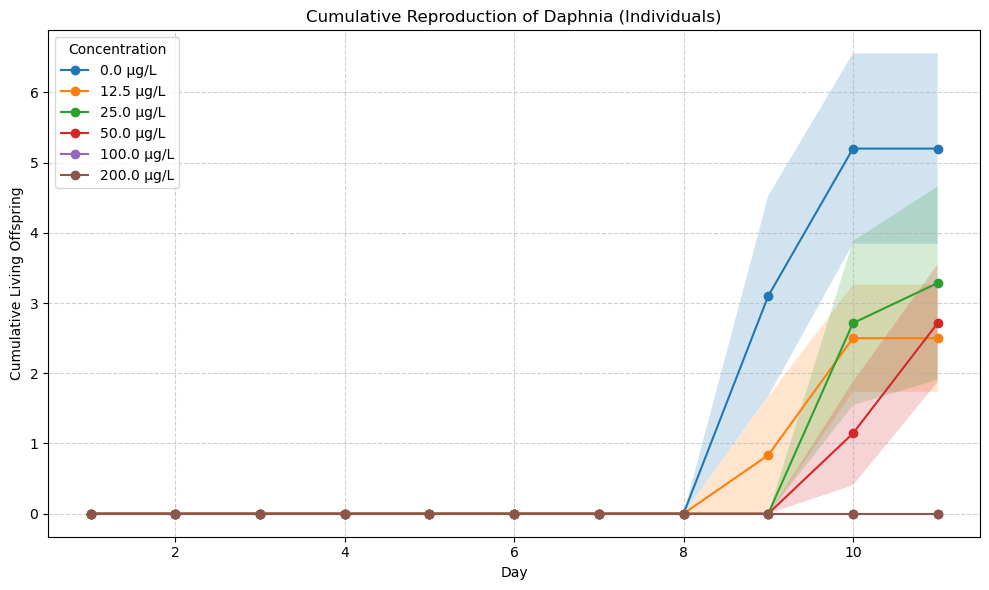

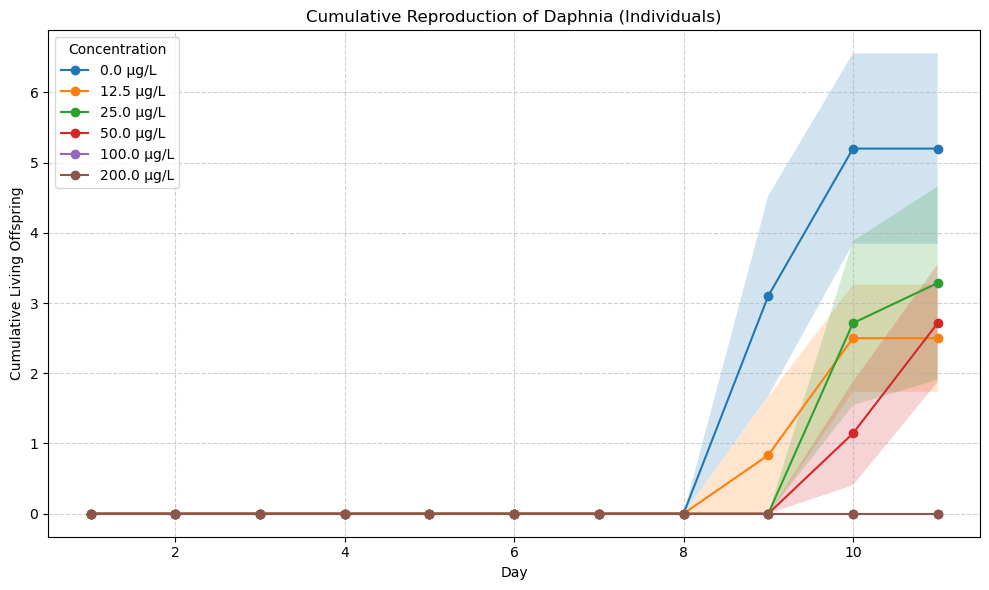

In [73]:
plot_cumulative_reproduction_with_variability(daphnia_df_cleaned, output_path=None)

# Growth Measurement

In [22]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import kruskal, mannwhitneyu
import itertools
from typing import Dict, List, Tuple, Optional, Union
import warnings

def check_parametric_assumptions(df: pd.DataFrame, alpha: float = 0.05) -> Dict[str, Union[str, bool, float]]:
    """
    Check parametric test assumptions for ANOVA.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with 'Conc.' and 'Length' columns
    alpha : float, default 0.05
        Significance level for assumption tests
        
    Returns
    -------
    Dict[str, Union[str, bool, float]]
        Dictionary containing assumption test results and recommendation
    """
    groups = [group['Length'].dropna() for name, group in df.groupby('Conc.')]
    
    # Remove empty groups
    groups = [group for group in groups if len(group) > 0]
    
    if len(groups) < 2:
        return {
            'normality_passed': False,
            'homoscedasticity_passed': False,
            'overall_recommendation': 'nonparametric',
            'reason': 'Insufficient groups for comparison'
        }
    
    # Check normality (Shapiro-Wilk for each group)
    normality_results = []
    for i, group in enumerate(groups):
        if len(group) >= 3:  # Minimum for Shapiro-Wilk
            _, p_val = stats.shapiro(group)
            normality_results.append(p_val > alpha)
        else:
            normality_results.append(False)
    
    normality_passed = all(normality_results) and len(normality_results) > 0
    
    # Check homoscedasticity (Levene's test)
    if len(groups) >= 2 and all(len(group) >= 2 for group in groups):
        _, levene_p = stats.levene(*groups)
        homoscedasticity_passed = levene_p > alpha
    else:
        homoscedasticity_passed = False
    
    # Overall recommendation
    if normality_passed and homoscedasticity_passed:
        recommendation = 'parametric'
    else:
        recommendation = 'nonparametric'
    
    return {
        'normality_passed': normality_passed,
        'homoscedasticity_passed': homoscedasticity_passed,
        'overall_recommendation': recommendation,
        'levene_p_value': levene_p if 'levene_p' in locals() else None
    }

def perform_parametric_analysis(df: pd.DataFrame, alpha: float = 0.05) -> Dict[str, str]:
    """
    Perform one-way ANOVA followed by Tukey's HSD post-hoc test.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with 'Conc.' and 'Length' columns
    alpha : float, default 0.05
        Significance level for statistical tests
        
    Returns
    -------
    Dict[str, str]
        Dictionary mapping concentration levels to letter symbols
    """
    from scipy.stats import f_oneway
    try:
        from scipy.stats import tukey_hsd
    except ImportError:
        # Fallback for older scipy versions
        warnings.warn("Tukey HSD not available, using Bonferroni correction with t-tests")
        return perform_nonparametric_analysis(df, alpha)
    
    groups = []
    group_names = []
    
    for name, group in df.groupby('Conc.'):
        length_data = group['Length'].dropna()
        if len(length_data) > 0:
            groups.append(length_data)
            group_names.append(name)
    
    if len(groups) < 2:
        return {str(group_names[0]) if group_names else '0': 'a'}
    
    # Perform ANOVA
    f_stat, p_value = f_oneway(*groups)
    
    if p_value >= alpha:
        # No significant difference, all groups get same letter
        return {str(name): 'a' for name in group_names}
    
    # Perform Tukey's HSD
    try:
        tukey_result = tukey_hsd(*groups)
        pairwise_p = tukey_result.pvalue
        
        # Convert to letter symbols
        return _generate_letter_symbols(group_names, pairwise_p, alpha)
    
    except Exception as e:
        warnings.warn(f"Tukey HSD failed: {e}. Using nonparametric approach.")
        return perform_nonparametric_analysis(df, alpha)

def perform_nonparametric_analysis(df: pd.DataFrame, alpha: float = 0.05) -> Dict[str, str]:
    """
    Perform Kruskal-Wallis test followed by Mann-Whitney U pairwise comparisons.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with 'Conc.' and 'Length' columns
    alpha : float, default 0.05
        Significance level for statistical tests
        
    Returns
    -------
    Dict[str, str]
        Dictionary mapping concentration levels to letter symbols
    """
    groups = []
    group_names = []
    
    for name, group in df.groupby('Conc.'):
        length_data = group['Length'].dropna()
        if len(length_data) > 0:
            groups.append(length_data)
            group_names.append(name)
    
    if len(groups) < 2:
        return {str(group_names[0]) if group_names else '0': 'a'}
    
    # Perform Kruskal-Wallis test
    h_stat, p_value = kruskal(*groups)
    
    if p_value >= alpha:
        # No significant difference, all groups get same letter
        return {str(name): 'a' for name in group_names}
    
    # Perform pairwise Mann-Whitney U tests with Bonferroni correction
    n_comparisons = len(groups) * (len(groups) - 1) // 2
    bonferroni_alpha = alpha / n_comparisons
    
    pairwise_p = np.ones((len(groups), len(groups)))
    
    for i, j in itertools.combinations(range(len(groups)), 2):
        try:
            _, p_val = mannwhitneyu(groups[i], groups[j], alternative='two-sided')
            pairwise_p[i, j] = p_val
            pairwise_p[j, i] = p_val
        except Exception:
            pairwise_p[i, j] = 1.0
            pairwise_p[j, i] = 1.0
    
    return _generate_letter_symbols(group_names, pairwise_p, bonferroni_alpha)

def _generate_letter_symbols(group_names: List, pairwise_p: np.ndarray, alpha: float) -> Dict[str, str]:
    """
    Generate letter symbols based on pairwise p-values using a proper algorithm.
    
    Parameters
    ----------
    group_names : List
        List of group names
    pairwise_p : np.ndarray
        Matrix of pairwise p-values
    alpha : float
        Significance level
        
    Returns
    -------
    Dict[str, str]
        Dictionary mapping group names to letter symbols
    """
    n_groups = len(group_names)
    letters = 'abcdefghijklmnopqrstuvwxyz'
    
    # Create significance matrix (True = significantly different)
    sig_matrix = pairwise_p < alpha
    
    # Initialize letter assignments
    letter_assignments = {}
    letter_counter = 0
    
    # Sort groups by their means for consistent assignment
    group_data = {}
    for i, name in enumerate(group_names):
        group_data[name] = {'index': i, 'assigned_letters': set()}
    
    # Process each group
    for i, group_name in enumerate(group_names):
        current_letters = set()
        
        # Check which existing letters this group can share
        for j in range(i):
            other_name = group_names[j]
            # If not significantly different, can share letters
            if not sig_matrix[i, j]:
                if other_name in letter_assignments:
                    current_letters.update(letter_assignments[other_name].split())
        
        # If no compatible letters found, assign new letter
        if not current_letters:
            if letter_counter < len(letters):
                current_letters.add(letters[letter_counter])
                letter_counter += 1
            else:
                current_letters.add(f'group_{letter_counter}')
                letter_counter += 1
        
        # Assign letters to current group
        letter_assignments[str(group_name)] = ''.join(sorted(current_letters))
        
        # Update previous groups that can share letters with current group
        for j in range(i):
            other_name = group_names[j]
            if not sig_matrix[i, j]:  # Not significantly different
                # Merge letter sets
                other_letters = set(letter_assignments[str(other_name)])
                merged_letters = other_letters.union(current_letters)
                letter_assignments[str(other_name)] = ''.join(sorted(merged_letters))
                letter_assignments[str(group_name)] = ''.join(sorted(merged_letters))
    
    return letter_assignments

def analyze_moult_lengths_by_date(df: pd.DataFrame, 
                                 analysis_date: str,
                                 alpha: float = 0.05, 
                                 force_test: Optional[str] = None) -> Dict[str, Union[str, float, Dict]]:
    """
    Analyze moult length differences between concentration groups for a specific date.
    
    This function performs statistical analysis on moult length data from OECD 211 tests,
    comparing different concentration groups on a specified date. It filters out any
    "error" entries in the Length column and performs either parametric (ANOVA + Tukey HSD) 
    or nonparametric (Kruskal-Wallis + Mann-Whitney U) tests based on assumption checking.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing OECD 211 test data with columns:
        - 'Conc.': Concentration levels (treatment groups)
        - 'Flask Number': Individual flask identifiers
        - 'Date': Date of measurement (format: 'DD/MM/YY')
        - 'Moult Collected': Whether moult was collected ('Yes'/'No')
        - 'Length': Moult length measurements in micrometers
        - Other columns as per OECD 211 protocol
        
    analysis_date : str
        Specific date to analyze (format: 'DD/MM/YY', e.g., '25/05/25')
        
    alpha : float, default 0.05
        Significance level for statistical tests. Used for both assumption checking
        and hypothesis testing.
        
    force_test : str, optional, default None
        Force use of specific test type ('parametric' or 'nonparametric').
        If None, appropriate test is selected based on assumption checking.
        Options:
        - None: Automatic selection based on normality and homoscedasticity
        - 'parametric': Force ANOVA + Tukey HSD
        - 'nonparametric': Force Kruskal-Wallis + Mann-Whitney U
        
    Returns
    -------
    Dict[str, Union[str, float, Dict]]
        Dictionary containing analysis results:
        {
            'analysis_date': str,
            'n_total_measurements': int,
            'concentrations_analyzed': List[str],
            'test_used': str,
            'overall_p_value': float,
            'letter_symbols': Dict[str, str],
            'group_stats': Dict[str, Dict],
            'assumptions': Dict (only if force_test is None),
            'excluded_measurements': int
        }
        
        Where:
        - 'analysis_date': Date analyzed
        - 'n_total_measurements': Total valid measurements included
        - 'concentrations_analyzed': List of concentration levels analyzed
        - 'test_used': Type of statistical test performed
        - 'overall_p_value': P-value from omnibus test (ANOVA/Kruskal-Wallis)
        - 'letter_symbols': Letter assignments for post-hoc comparisons
        - 'group_stats': Descriptive statistics for each concentration group
        - 'assumptions': Results of assumption testing (if applicable)
        - 'excluded_measurements': Number of measurements excluded due to errors
        
    Examples
    --------
    >>> # Analyze moult lengths for specific date
    >>> results = analyze_moult_lengths_by_date(df, '25/05/25', alpha=0.05)
    >>> 
    >>> # Force nonparametric tests
    >>> results = analyze_moult_lengths_by_date(df, '25/05/25', alpha=0.05, 
    ...                                        force_test='nonparametric')
    >>> 
    >>> # Print results
    >>> print_date_analysis_results(results, alpha=0.05)
    
    Notes
    -----
    - Only rows where 'Moult Collected' == 'Yes' and date matches analysis_date are analyzed
    - Any entries with "error" in the 'Length' column are automatically excluded
    - Concentrations with no valid measurements are excluded from analysis
    - Parametric assumptions (normality and homoscedasticity) are checked using 
      Shapiro-Wilk and Levene's tests respectively
    - Post-hoc comparisons use appropriate corrections (Tukey HSD for parametric,
      Bonferroni correction for nonparametric)
    - Letter symbols follow standard convention: groups sharing letters are not
      significantly different
    
    Raises
    ------
    ValueError
        If required columns are missing from the DataFrame or invalid date format
    TypeError
        If input parameters are of incorrect type
        
    See Also
    --------
    check_parametric_assumptions : Check assumptions for parametric tests
    perform_parametric_analysis : Perform ANOVA + Tukey HSD
    perform_nonparametric_analysis : Perform Kruskal-Wallis + Mann-Whitney U
    print_date_analysis_results : Print formatted results
    """
    
    # Validate input parameters
    if not isinstance(df, pd.DataFrame):
        raise TypeError("df must be a pandas DataFrame")
    
    required_cols = ['Conc.', 'Flask Number', 'Date', 'Moult Collected', 'Length']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    if force_test is not None and force_test not in ['parametric', 'nonparametric']:
        raise ValueError("force_test must be None, 'parametric', or 'nonparametric'")
    
    # Filter data for specific date and moult collections only
    date_data = df[df['Date'] == analysis_date].copy()
    moult_data = date_data[date_data['Moult Collected'] == 'Yes'].copy()
    
    if len(moult_data) == 0:
        warnings.warn(f"No moult collection data found for date: {analysis_date}")
        return {
            'analysis_date': analysis_date,
            'n_total_measurements': 0,
            'concentrations_analyzed': [],
            'test_used': 'None',
            'overall_p_value': np.nan,
            'letter_symbols': {},
            'group_stats': {},
            'excluded_measurements': 0
        }
    
    # Count initial measurements before filtering
    initial_count = len(moult_data)
    
    # Remove "error" entries and non-numeric entries from Length column
    def is_valid_length(length_val):
        if pd.isna(length_val):
            return False
        if isinstance(length_val, str):
            if 'error' in str(length_val).lower():
                return False
            try:
                float(length_val)
                return True
            except (ValueError, TypeError):
                return False
        try:
            float(length_val)
            return True
        except (ValueError, TypeError):
            return False
    
    moult_data = moult_data[moult_data['Length'].apply(is_valid_length)].copy()
    
    # Convert Length to numeric
    moult_data['Length'] = pd.to_numeric(moult_data['Length'], errors='coerce')
    moult_data = moult_data.dropna(subset=['Length'])
    
    excluded_count = initial_count - len(moult_data)
    
    if len(moult_data) == 0:
        warnings.warn(f"No valid length measurements found for date: {analysis_date}")
        return {
            'analysis_date': analysis_date,
            'n_total_measurements': 0,
            'concentrations_analyzed': [],
            'test_used': 'None',
            'overall_p_value': np.nan,
            'letter_symbols': {},
            'group_stats': {},
            'excluded_measurements': excluded_count
        }
    
    # Get unique concentrations with valid data
    concentrations = sorted(moult_data['Conc.'].unique())
    
    if len(concentrations) < 2:
        warnings.warn(f"Insufficient concentration groups for analysis on {analysis_date}")
        return {
            'analysis_date': analysis_date,
            'n_total_measurements': len(moult_data),
            'concentrations_analyzed': [str(c) for c in concentrations],
            'test_used': 'None',
            'overall_p_value': np.nan,
            'letter_symbols': {str(concentrations[0]): 'a'} if concentrations else {},
            'group_stats': {},
            'excluded_measurements': excluded_count
        }
    
    # Calculate group statistics
    group_stats = {}
    for conc in concentrations:
        conc_data = moult_data[moult_data['Conc.'] == conc]['Length']
        group_stats[str(conc)] = {
            'n': len(conc_data),
            'mean': float(np.mean(conc_data)),
            'std': float(np.std(conc_data, ddof=1)) if len(conc_data) > 1 else 0.0,
            'median': float(np.median(conc_data)),
            'min': float(np.min(conc_data)),
            'max': float(np.max(conc_data))
        }
    
    # Check assumptions unless forced to use specific test
    if force_test is None:
        assumptions = check_parametric_assumptions(moult_data, alpha)
        test_type = assumptions['overall_recommendation']
    else:
        test_type = force_test
        assumptions = None
    
    # In the parametric analysis section:
    if test_type == 'parametric':
        letter_symbols = perform_parametric_analysis(moult_data, alpha)
        test_description = "One-way ANOVA + Tukey's HSD"
        
        # Get ANOVA F-value and p-value
        groups = [group['Length'].dropna() for _, group in moult_data.groupby('Conc.')]
        groups = [g for g in groups if len(g) > 0]
        if len(groups) >= 2:
            f_value, overall_p = stats.f_oneway(*groups)  # Now capturing both outputs
        else:
            f_value, overall_p = float('nan'), 1.0  # Handle case with <2 groups
            
    else:
        letter_symbols = perform_nonparametric_analysis(moult_data, alpha)
        test_description = "Kruskal-Wallis + Mann-Whitney U (Bonferroni corrected)"
        
        # Get Kruskal-Wallis p-value
        groups = [group['Length'].dropna() for _, group in moult_data.groupby('Conc.')]
        groups = [g for g in groups if len(g) > 0]
        if len(groups) >= 2:
            _, overall_p = kruskal(*groups)
        else:
            overall_p = 1.0
    
    # Compile results
    results = {
        'analysis_date': analysis_date,
        'n_total_measurements': len(moult_data),
        'concentrations_analyzed': [str(c) for c in concentrations],
        'test_used': test_description,
        'f_value': float(f_value) if test_type == 'parametric' else None,
        'overall_p_value': float(overall_p),
        'letter_symbols': letter_symbols,
        'group_stats': group_stats,
        'excluded_measurements': excluded_count
    }
    
    if assumptions is not None:
        results['assumptions'] = assumptions
    
    return results

def print_date_analysis_results(results: Dict, alpha: float = 0.05) -> None:
    """
    Print formatted results for date-specific moult length analysis.
    
    Parameters
    ----------
    results : Dict
        Results dictionary from analyze_moult_lengths_by_date()
    alpha : float, default 0.05
        Significance level used in the analysis
    """
    
    if results['n_total_measurements'] == 0:
        print(f"No valid data found for analysis on {results['analysis_date']}")
        return
    
    print("=" * 60)
    print(f"MOULT LENGTH ANALYSIS - {results['analysis_date']}")
    print("=" * 60)
    print()
    
    print("=" * 60)
    print("RESULTS INTERPRETATION")
    print("=" * 60)
    
    print("Letter symbol interpretation:")
    print("- Groups with the same letter are NOT significantly different")
    print("- Groups with different letters ARE significantly different")
    print(f"- Statistical test used: {results['test_used']}")
    print(f"- Significance level: α = {alpha}")
    print()
    
    print("Statistical groupings:")
    
    # Sort concentrations numerically for consistent output
    sorted_concentrations = sorted(results['concentrations_analyzed'], 
                                 key=lambda x: float(x) if str(x).replace('.', '').isdigit() else float('inf'))
    
    for conc in sorted_concentrations:
        if conc in results['group_stats'] and conc in results['letter_symbols']:
            stats = results['group_stats'][conc]
            letter = results['letter_symbols'][conc]
            print(f"Concentration {conc}: Group '{letter}' (n={stats['n']}, mean={stats['mean']:.1f})")
    
    print()
    
    # Additional information
    print("=" * 60)
    print("ADDITIONAL INFORMATION")
    print("=" * 60)
    print(f"Analysis date: {results['analysis_date']}")
    print(f"Total valid measurements: {results['n_total_measurements']}")
    print(f"Excluded measurements (errors): {results['excluded_measurements']}")
    print(f"Overall p-value: {results['overall_p_value']:.6f}")
    
    if results['overall_p_value'] < alpha:
        print("Overall result: SIGNIFICANT DIFFERENCE DETECTED")
    else:
        print("Overall result: No significant difference between groups")

    if results['test_used'].startswith("One-way ANOVA") and results['f_value'] is not None:
        df_between = len(results['concentrations_analyzed']) - 1
        df_within = results['n_total_measurements'] - len(results['concentrations_analyzed'])
        print(f"F-value: F({df_between},{df_within}) = {results['f_value']:.3f}")
    
    print()
    print("Detailed group statistics:")
    for conc in sorted_concentrations:
        if conc in results['group_stats']:
            stats = results['group_stats'][conc]
            print(f"Concentration {conc}:")
            print(f"  - Sample size: {stats['n']}")
            print(f"  - Mean ± SD: {stats['mean']:.2f} ± {stats['std']:.2f} μm")
            print(f"  - Median: {stats['median']:.2f} μm")
            print(f"  - Range: {stats['min']:.2f} - {stats['max']:.2f} μm")
    
    if 'assumptions' in results and results['assumptions']:
        print()
        print("Parametric test assumptions:")
        assumptions = results['assumptions']
        print(f"- Normality test: {'PASSED' if assumptions['normality_passed'] else 'FAILED'}")
        print(f"- Homoscedasticity test: {'PASSED' if assumptions['homoscedasticity_passed'] else 'FAILED'}")
        if assumptions['levene_p_value'] is not None:
            print(f"- Levene's test p-value: {assumptions['levene_p_value']:.6f}")
    
    print()

# Example usage:
if __name__ == "__main__":
    # Example with your actual CSV data structure for 25/05/25
    
    df_example = daphnia_df_cleaned
    
    # Add some "error" entries to test filtering
    df_example.loc[2, 'Length'] = 'error'
    df_example.loc[15, 'Length'] = 'measurement error'
    
    print("EXAMPLE: Analyzing moult lengths for 25/05/25")
    print("=" * 60)
    
    # Run analysis for specific date
    results = analyze_moult_lengths_by_date(df_example, '25/05/25', alpha=0.05)
    
    # Print results in requested format
    print_date_analysis_results(results, alpha=0.05)

EXAMPLE: Analyzing moult lengths for 25/05/25
MOULT LENGTH ANALYSIS - 25/05/25

RESULTS INTERPRETATION
Letter symbol interpretation:
- Groups with the same letter are NOT significantly different
- Groups with different letters ARE significantly different
- Statistical test used: One-way ANOVA + Tukey's HSD
- Significance level: α = 0.05

Statistical groupings:
Concentration 0.0: Group 'a' (n=8, mean=727.9)
Concentration 12.5: Group 'a' (n=4, mean=767.8)
Concentration 25.0: Group 'a' (n=6, mean=707.8)
Concentration 50.0: Group 'a' (n=5, mean=765.9)
Concentration 100.0: Group 'a' (n=10, mean=761.4)
Concentration 200.0: Group 'a' (n=5, mean=749.9)

ADDITIONAL INFORMATION
Analysis date: 25/05/25
Total valid measurements: 38
Excluded measurements (errors): 2
Overall p-value: 0.728899
Overall result: No significant difference between groups
F-value: F(5,32) = 0.561

Detailed group statistics:
Concentration 0.0:
  - Sample size: 8
  - Mean ± SD: 727.95 ± 59.11 μm
  - Median: 730.52 μm
  - Ran

## Oxygen and pH by Checks

In [16]:
import pandas as pd
import numpy as np
from typing import Dict, Any
from datetime import datetime

def analyze_ph_oxygen(df: pd.DataFrame) -> Dict[str, Any]:
    """
    Analyze pH and dissolved oxygen concentrations per OECD 211 requirements.

    Verifies that dissolved oxygen is above 3 mg/L and pH is within 6-9 range,
    with variation not exceeding 1.5 units in any test (flask across all days).

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe containing at minimum:
        - 'Conc.' (concentration)
        - 'Flask Number'
        - 'pH Renewed'
        - 'pH Old'
        - 'O2 (mg/L) Renewed'
        - 'O2 (mg/L) Old'
        - 'Date'

    Returns
    -------
    Dict[str, Any]
        Dictionary containing analysis results:
        - 'oxygen_violations': List of records where oxygen < 3 mg/L
        - 'ph_range_violations': List of records where pH is outside 6-9
        - 'ph_variation_violations': List of flasks with pH variation > 1.5
        - 'summary': Summary statistics and compliance status, including total counts
    """
    # Initialize result dictionary
    results = {
        'oxygen_violations': [],
        'ph_range_violations': [],
        'ph_variation_violations': [],
        'summary': {}
    }

    # Convert pH and oxygen columns to numeric, handling non-numeric values
    for col in ['pH Renewed', 'pH Old', 'O2 (mg/L) Renewed', 'O2 (mg/L) Old']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Check oxygen levels (< 3 mg/L)
    oxygen_cols = ['O2 (mg/L) Renewed', 'O2 (mg/L) Old']
    for col in oxygen_cols:
        violations = df[
            (df[col].notna()) & (df[col] < 3)
        ][['Conc.', 'Flask Number', 'Date', col]].to_dict('records')
        results['oxygen_violations'].extend([
            {
                'Concentration': v['Conc.'],
                'Flask': v['Flask Number'],
                'Date': v['Date'],
                'Parameter': col,
                'Value': v[col]
            } for v in violations
        ])

    # Check pH range (6-9)
    ph_cols = ['pH Renewed', 'pH Old']
    for col in ph_cols:
        violations = df[
            (df[col].notna()) & ((df[col] < 6) | (df[col] > 9))
        ][['Conc.', 'Flask Number', 'Date', col]].to_dict('records')
        results['ph_range_violations'].extend([
            {
                'Concentration': v['Conc.'],
                'Flask': v['Flask Number'],
                'Date': v['Date'],
                'Parameter': col,
                'Value': v[col]
            } for v in violations
        ])

    # Check pH variation per flask (> 1.5 units)
    ph_data = df[['Conc.', 'Flask Number', 'pH Renewed', 'pH Old']].copy().reset_index(drop=True)
    ph_melted = pd.melt(
        ph_data,
        id_vars=['Conc.', 'Flask Number'],
        value_vars=['pH Renewed', 'pH Old'],
        var_name='pH_type',
        value_name='pH'
    )
    ph_melted = ph_melted[ph_melted['pH'].notna()]
    ph_variation = ph_melted.groupby(['Conc.', 'Flask Number'])['pH'].agg(
        lambda x: x.max() - x.min() if len(x) > 0 else np.nan
    ).reset_index()
    variation_violations = ph_variation[ph_variation['pH'] > 1.5]
    results['ph_variation_violations'] = [
        {
            'Concentration': row['Conc.'],
            'Flask': row['Flask Number'],
            'pH Variation': round(row['pH'], 3)
        } for _, row in variation_violations.iterrows()
    ]

    # Compile summary statistics
    results['summary'] = {
        'total_oxygen_measurements': df[oxygen_cols].notna().sum().sum(),
        'oxygen_renewed_count': df['O2 (mg/L) Renewed'].notna().sum(),
        'oxygen_old_count': df['O2 (mg/L) Old'].notna().sum(),
        'oxygen_violations_count': len(results['oxygen_violations']),
        'oxygen_compliance': len(results['oxygen_violations']) == 0,
        'total_ph_measurements': df[ph_cols].notna().sum().sum(),
        'ph_renewed_count': df['pH Renewed'].notna().sum(),
        'ph_old_count': df['pH Old'].notna().sum(),
        'ph_range_violations_count': len(results['ph_range_violations']),
        'ph_range_compliance': len(results['ph_range_violations']) == 0,
        'flasks_with_ph_variation_violations': len(results['ph_variation_violations']),
        'ph_variation_compliance': len(results['ph_variation_violations']) == 0,
        'overall_compliance': (
            len(results['oxygen_violations']) == 0 and
            len(results['ph_range_violations']) == 0 and
            len(results['ph_variation_violations']) == 0
        )
    }

    return results

def main(df) -> Dict[str, Any]:
    """
    Main function to load data and perform pH and oxygen analysis.

    Parameters
    ----------
    file_path : str
        Path to input CSV file

    Returns
    -------
    Dict[str, Any]
        Analysis results from analyze_ph_oxygen
    """
    print("=== pH and Oxygen Analysis per OECD 211 ===\n")
    
    try:
        results = analyze_ph_oxygen(df)
        
        # Print detailed summary
        print("\nAnalysis Summary:")
        print(f"   Total oxygen measurements: {results['summary']['total_oxygen_measurements']:,}")
        print(f"      - O2 Renewed: {results['summary']['oxygen_renewed_count']:,}")
        print(f"      - O2 Old: {results['summary']['oxygen_old_count']:,}")
        print(f"   Oxygen violations (<3 mg/L): {results['summary']['oxygen_violations_count']}")
        print(f"   Oxygen compliance: {results['summary']['oxygen_compliance']}")
        print(f"   Total pH measurements: {results['summary']['total_ph_measurements']:,}")
        print(f"      - pH Renewed: {results['summary']['ph_renewed_count']:,}")
        print(f"      - pH Old: {results['summary']['ph_old_count']:,}")
        print(f"   pH range violations (outside 6-9): {results['summary']['ph_range_violations_count']}")
        print(f"   pH range compliance: {results['summary']['ph_range_compliance']}")
        print(f"   Flasks with pH variation > 1.5: {results['summary']['flasks_with_ph_variation_violations']}")
        print(f"   pH variation compliance: {results['summary']['ph_variation_compliance']}")
        print(f"   Overall OECD 211 compliance: {results['summary']['overall_compliance']}")
        
        if results['oxygen_violations']:
            print("\nOxygen Violations:")
            for v in results['oxygen_violations']:
                print(f"   Conc: {v['Concentration']}, Flask: {v['Flask']}, "
                      f"Date: {v['Date']}, {v['Parameter']}: {v['Value']}")
        
        if results['ph_range_violations']:
            print("\npH Range Violations:")
            for v in results['ph_range_violations']:
                print(f"   Conc: {v['Concentration']}, Flask: {v['Flask']}, "
                      f"Date: {v['Date']}, {v['Parameter']}: {v['Value']}")
        
        if results['ph_variation_violations']:
            print("\npH Variation Violations:")
            for v in results['ph_variation_violations']:
                print(f"   Conc: {v['Concentration']}, Flask: {v['Flask']}, "
                      f"pH Variation: {v['pH Variation']}")
        
        return results
    
    except Exception as e:
        print(f"\nError during analysis: {str(e)}")
        raise

In [17]:
main(daphnia_df_cleaned)

=== pH and Oxygen Analysis per OECD 211 ===


Analysis Summary:
   Total oxygen measurements: 133
      - O2 Renewed: 79
      - O2 Old: 54
   Oxygen violations (<3 mg/L): 0
   Oxygen compliance: True
   Total pH measurements: 138
      - pH Renewed: 80
      - pH Old: 58
   pH range violations (outside 6-9): 51
   pH range compliance: False
   Flasks with pH variation > 1.5: 0
   pH variation compliance: True
   Overall OECD 211 compliance: False

pH Range Violations:
   Conc: 12.5, Flask: 4, Date: 2025-06-01 00:00:00, pH Renewed: 9.041
   Conc: 0.0, Flask: 4, Date: 2025-05-26 00:00:00, pH Old: 9.075
   Conc: 0.0, Flask: 5, Date: 2025-05-26 00:00:00, pH Old: 9.071
   Conc: 0.0, Flask: 6, Date: 2025-05-26 00:00:00, pH Old: 9.063
   Conc: 0.0, Flask: 1, Date: 2025-05-28 00:00:00, pH Old: 9.016
   Conc: 0.0, Flask: 2, Date: 2025-05-28 00:00:00, pH Old: 9.03
   Conc: 0.0, Flask: 3, Date: 2025-05-28 00:00:00, pH Old: 9.214
   Conc: 0.0, Flask: 1, Date: 2025-05-30 00:00:00, pH Old: 9.128
  

{'oxygen_violations': [],
 'ph_range_violations': [{'Concentration': 12.5,
   'Flask': 4,
   'Date': Timestamp('2025-06-01 00:00:00'),
   'Parameter': 'pH Renewed',
   'Value': 9.041},
  {'Concentration': 0.0,
   'Flask': 4,
   'Date': Timestamp('2025-05-26 00:00:00'),
   'Parameter': 'pH Old',
   'Value': 9.075},
  {'Concentration': 0.0,
   'Flask': 5,
   'Date': Timestamp('2025-05-26 00:00:00'),
   'Parameter': 'pH Old',
   'Value': 9.071},
  {'Concentration': 0.0,
   'Flask': 6,
   'Date': Timestamp('2025-05-26 00:00:00'),
   'Parameter': 'pH Old',
   'Value': 9.063},
  {'Concentration': 0.0,
   'Flask': 1,
   'Date': Timestamp('2025-05-28 00:00:00'),
   'Parameter': 'pH Old',
   'Value': 9.016},
  {'Concentration': 0.0,
   'Flask': 2,
   'Date': Timestamp('2025-05-28 00:00:00'),
   'Parameter': 'pH Old',
   'Value': 9.03},
  {'Concentration': 0.0,
   'Flask': 3,
   'Date': Timestamp('2025-05-28 00:00:00'),
   'Parameter': 'pH Old',
   'Value': 9.214},
  {'Concentration': 0.0,
   'F